<a href="https://colab.research.google.com/github/saritmaitra/AL-VAR-VECM-/blob/main/AL_VAR__FORECAST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings
from pandas import DataFrame, merge, concat
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 1. Data loading and initial preprocessing:

In [98]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data (2).csv


In [99]:
df = pd.read_csv("AL_final_data.csv")
df.head()

<IPython.core.display.Javascript object>

,Unnamed: 0,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
0,0,2020-05-01 00:00:00,2877.12,1094465.00,1258140.00,1695.85,8846.12,107301000.00
1,1,2020-05-01 00:01:00,2875.38,1094215.00,1257935.00,1695.60,8841.25,107368000.00
2,2,2020-05-01 00:02:00,2874.62,1094165.00,1257765.00,1695.65,8837.75,107376500.00
3,3,2020-05-01 00:03:00,2874.12,1094115.00,1257565.00,1695.40,8836.75,107381500.00
4,4,2020-05-01 00:04:00,2875.25,1094190.00,1257535.00,1694.85,8841.12,107376500.00


In [100]:
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df.tail()

,timestamp,es,eurusd,gbpusd,gc,nq,usdjpy
29340,2020-05-29 20:56:00,3027.25,1111740.00,1235400.00,1731.50,9588.62,107675000.00
29341,2020-05-29 20:57:00,3027.25,1111750.00,1235450.00,1731.20,9588.50,107830000.00
29342,2020-05-29 20:58:00,3027.25,1111650.00,1235450.00,1731.45,9588.62,107830000.00
29343,2020-05-29 20:59:00,3027.25,1113400.00,1235450.00,1731.30,9587.38,107835000.00
29344,2020-05-29 21:00:00,3027.25,1113400.00,1237150.00,1731.35,9591.12,107835000.00


In [101]:
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df.info()

<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [145]:
df.drop_duplicates(keep=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   es      29345 non-null  float64
 1   eurusd  29345 non-null  float64
 2   gbpusd  29345 non-null  float64
 3   gc      29345 non-null  float64
 4   nq      29345 non-null  float64
 5   usdjpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [102]:
# spliting train/test
nobs = 10 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
print('Description of diff data:'); print(train_trans.describe());

(29335, 6)
(10, 6)
Description of diff data:
            es    eurusd    gbpusd       gc       nq      usdjpy
count 29334.00  29334.00  29334.00 29334.00 29334.00    29334.00
mean      0.01      0.56     -0.77     0.00     0.03       16.19
std       1.12    288.72    334.81     0.52     3.72    47921.86
min     -37.75 -18615.00 -18420.00    -9.15  -131.50 -4778500.00
25%      -0.50    -50.00   -100.00    -0.20    -1.50    -5500.00
50%       0.00      0.00      0.00     0.00     0.00        0.00
75%       0.50     50.00    100.00     0.20     1.62     5500.00
max      26.88  18290.00  17970.00    11.95    84.75  4752500.00


In [103]:
print(train_trans.corr())

         es  eurusd  gbpusd    gc   nq  usdjpy
es     1.00    0.06    0.17  0.09 0.88    0.05
eurusd 0.06    1.00    0.15  0.06 0.05   -0.02
gbpusd 0.17    0.15    1.00  0.08 0.16   -0.03
gc     0.09    0.06    0.08  1.00 0.11   -0.04
nq     0.88    0.05    0.16  0.11 1.00    0.04
usdjpy 0.05   -0.02   -0.03 -0.04 0.04    1.00


## 1.1 Lag order selection:

### 1.1.1 Checking required lags through ACF/PACF:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

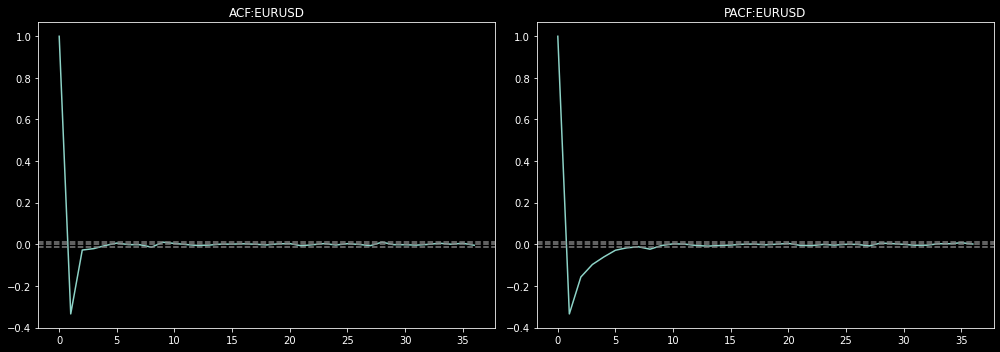

In [104]:
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

lag_acf = acf(train_trans.eurusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.eurusd, method = 'ols', nlags=36) 

plt.figure(figsize=(14,5))
plt.style.use('dark_background')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('ACF:EURUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.eurusd)),linestyle='--',color='gray')
plt.title('PACF:EURUSD')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

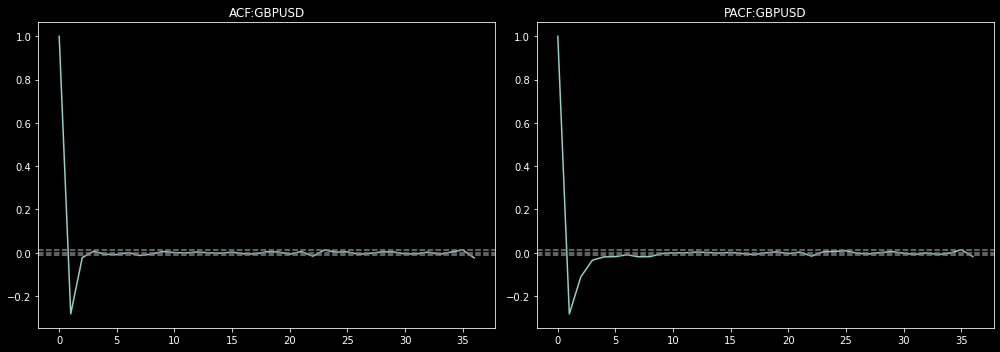

In [105]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.gbpusd, nlags=36, fft=False)
lag_pacf = pacf(train_trans.gbpusd, method = 'ols', nlags=36) 

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('ACF:GBPUSD')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gbpusd)),linestyle='--',color='gray')
plt.title('PACF:GBPUSD')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

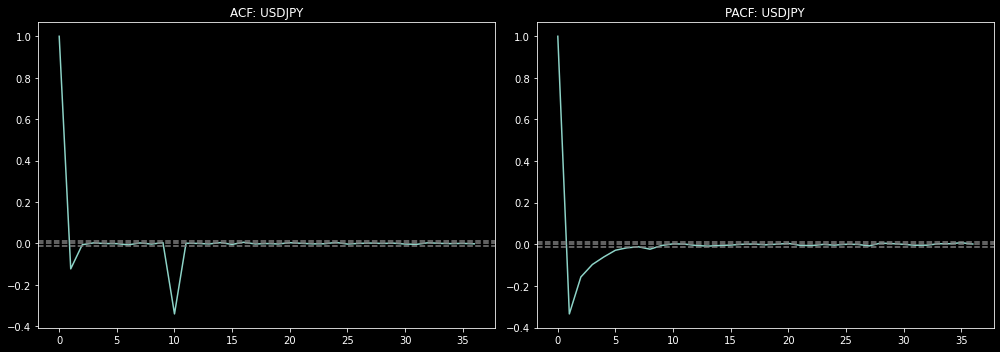

In [106]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.usdjpy, nlags=36, fft=False)
lag_pacf = pacf(train_trans.eurusd, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('ACF: USDJPY')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.usdjpy)),linestyle='--',color='gray')
plt.title('PACF: USDJPY')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

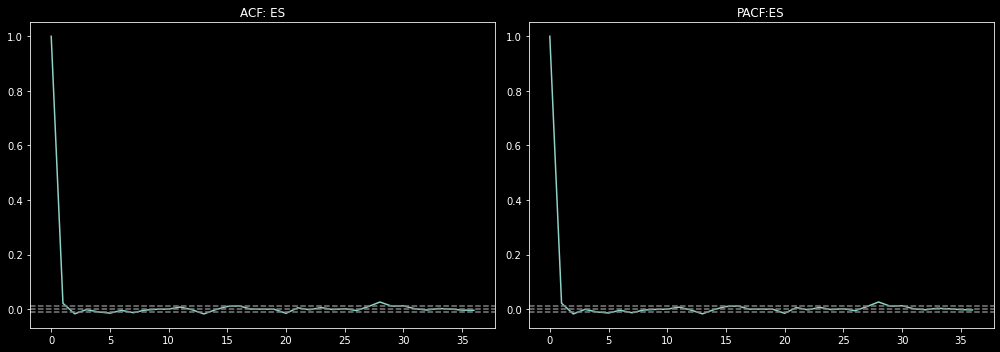

In [107]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.es, nlags=36, fft=False) 
lag_pacf = pacf(train_trans.es, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.title('ACF: ES')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.es)),linestyle='--',color='gray')
plt.title('PACF:ES')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

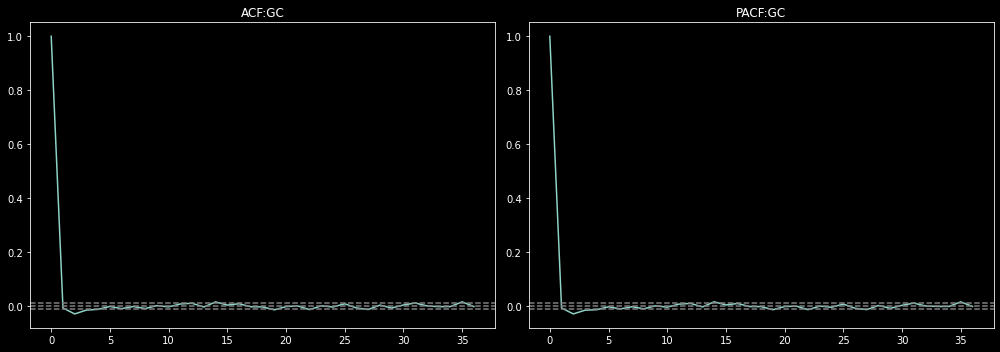

In [108]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.gc, nlags=36, fft=False) 
lag_pacf = pacf(train_trans.gc, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('ACF:GC')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.gc)),linestyle='--',color='gray')
plt.title('PACF:GC')
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

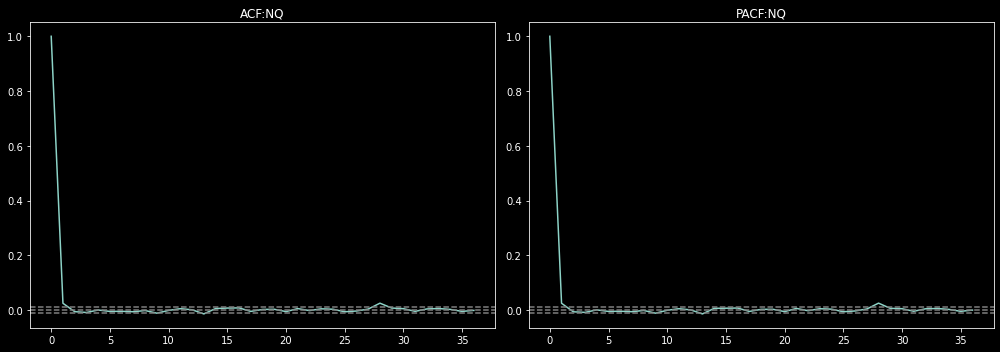

In [109]:
plt.figure(figsize=(14,5))

lag_acf = acf(train_trans.nq, nlags=36,fft=False) 
lag_pacf = pacf(train_trans.nq, method = 'ols', nlags=36)

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('ACF:NQ')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_trans.nq)),linestyle='--',color='gray')
plt.title('PACF:NQ')
plt.tight_layout()

We can conclude that the time series is correlated with itself shifted by 2 minutes.


### 1.1.2 Checking required lags through iteratively fitting:


In [110]:
from statsmodels.tsa.api import VAR
pd.options.display.float_format = "{:.2f}".format
model = VAR(train_trans.values)
for i in [1,2,3,4,5,6,7,8,9]:
    res = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', res.aic)
    print('BIC : ', res.bic)
    print('FPE : ', res.fpe)
    print('HQIC: ', res.hqic, '\n')

<IPython.core.display.Javascript object>

Lag Order = 1
AIC :  44.195319520382874
BIC :  44.20718437138775
FPE :  1.5623682101238008e+19
HQIC:  44.199130574833035 

Lag Order = 2
AIC :  44.13389889116869
BIC :  44.15593427502382
FPE :  1.4692941635557024e+19
HQIC:  44.14097678738766 

Lag Order = 3
AIC :  44.115701655798134
BIC :  44.147908182312875
FPE :  1.4427988745461723e+19
HQIC:  44.12604660027063 

Lag Order = 4
AIC :  44.108376492227464
BIC :  44.150754771269256
FPE :  1.432268753304119e+19
HQIC:  44.1219886914584 

Lag Order = 5
AIC :  44.10577923991063
BIC :  44.15832988140502
FPE :  1.4285536198373157e+19
HQIC:  44.122658900425144 

Lag Order = 6
AIC :  44.104630351501534
BIC :  44.16735396543217
FPE :  1.426913318307516e+19
HQIC:  44.12477767984497 

Lag Order = 7
AIC :  44.10362232986803
BIC :  44.176519526276685
FPE :  1.425475690042564e+19
HQIC:  44.12703753260595 

Lag Order = 8
AIC :  44.10343356586692
BIC :  44.18650495485348
FPE :  1.4252066455657558e+19
HQIC:  44.13011684958509 

Lag Order = 9
AIC :  44.104

- AIC drops to lowest at lag 8, then increases at lag 9 and then keeps increrasing. We will fo with lag 8 model.
- BIC drops to lowest at lag 3
- FPE drops to lowest at lag 8
- HQIC drops to lowest at lag 4

We shall try with lag 8 and lag3 to check which models proves better output.

### 1.1.3 Checking throgh VAR order selection:

In [111]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,44.45,44.45,2.015e+19,44.45
1,44.20,44.21,1.564e+19,44.20
2,44.13,44.16,1.471e+19,44.14
3,44.12,44.15,1.444e+19,44.13
4,44.11,44.15,1.433e+19,44.12
5,44.11,44.16,1.429e+19,44.12
6,44.11,44.17,1.428e+19,44.13
7,44.10,44.18,1.426e+19,44.13
8,44.10,44.19,1.426e+19,44.13
9,44.10,44.20,1.427e+19,44.13


This givex AIC & FPE as 12, BIC as 10, HQIC as 11

<IPython.core.display.Javascript object>

BEST ORDER 31 BEST AIC: 43.93692031249492


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

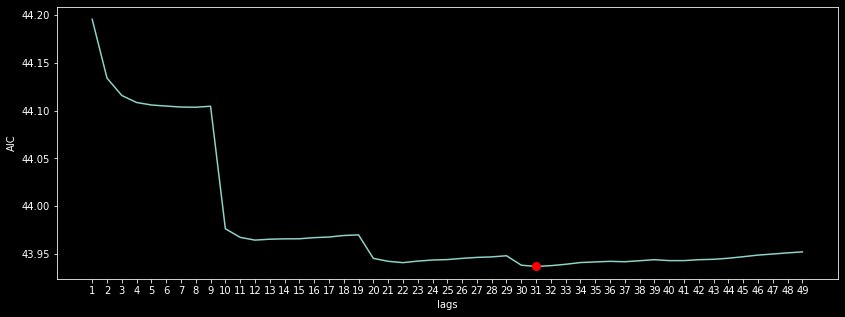

In [112]:
### FIND BEST VAR ORDER ###
AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train_trans.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

### PLOT AICs ### 
plt.style.use('dark_background')
plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(len(AIC)), range(1,50))
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

We have few lag values, let us try with 2 lags.

# **2 VAR model fitting with lags 2:**

In [113]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_2 = VAR(endog = train_trans).fit(maxlags = 2)
model_l_2.summary()

<IPython.core.display.Javascript object>

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 05, Nov, 2020
Time:                     07:37:15
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    44.1559
Nobs:                     29332.0    HQIC:                   44.1410
Log likelihood:          -896912.    FPE:                1.46929e+19
AIC:                      44.1339    Det(Omega_mle):     1.46539e+19
--------------------------------------------------------------------
Results for equation es
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004950         0.006520            0.759           0.448
L1.es             0.011154         0.012509            0.892           0.373
L1.eurusd         0.000092         0.000025            3.745           0.000
L1

- Top of the table shows the information for the model as a whole, including values of the information criteria, 
- Further down we shows the coefficient estimates and goodness-of-fit measures for each of the equations separately. 
- Each regression equation is separated by a horizontal line.

## 2.1 Durbin Watson Statistic:
Checking for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic. If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series. So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.


In [114]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_l_2.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))

es : 2.0
eurusd : 2.04
gbpusd : 2.01
gc : 2.0
nq : 2.0
usdjpy : 2.0


This is to determine the existence of multi-colinearity where variables are highly correlated. The statistic is a values between 0-4 and value 2 is idea, which means there is ni auto-correlation among the variables in the model.

The serial correlation looks alright. 

## 2.2 Resuals plot:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

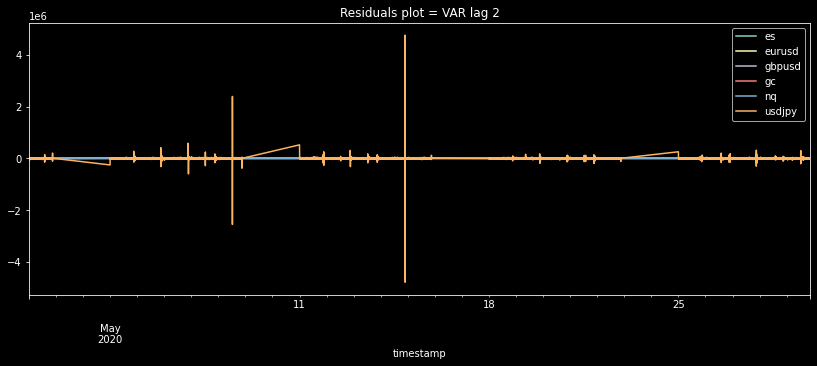

In [115]:
residuals = model_l_2.resid
residuals.plot(figsize=(14,5))
plt.title('Residuals plot = VAR lag 2')
plt.show()

In [116]:
print('GBPUSD-> EURUSD')
ca_1 = model_l_2.test_causality(causing=['gbpusd'], caused=['eurusd'], kind='wald',signif=0.05 )
print(ca_1)
print("**********************")
print('GBPUSD-> USDJPY')
ca_2 = model_l_2.test_causality(causing=['gbpusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_2)
print("**********************")
print('GBPUSD -> USDJPY, EURUSD')
ca_3 = model_l_2.test_causality(causing=['gbpusd'], caused=['usdjpy', 'eurusd'], kind='wald',signif=0.05 )
print(ca_3)
print("**********************")
print('EURUSD -> USDJPY')
ca_4 = model_l_2.test_causality(causing=['eurusd'], caused=['usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")
print('EURUSD -> GBPUSD, USDJPY')
ca_5 = model_l_2.test_causality(causing=['eurusd'], caused=['gbpusd', 'usdjpy'], kind='wald',signif=0.05 )
print(ca_4)
print("**********************")

GBPUSD-> EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause eurusd: reject at 5% significance level. Test statistic: 280.803, critical value: 5.991>, p-value: 0.000>
**********************
GBPUSD-> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic: 4.646, critical value: 5.991>, p-value: 0.098>
**********************
GBPUSD -> USDJPY, EURUSD
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: gbpusd does not Granger-cause [usdjpy, eurusd]: reject at 5% significance level. Test statistic: 283.874, critical value: 9.488>, p-value: 0.000>
**********************
EURUSD -> USDJPY
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: eurusd does not Granger-cause usdjpy: fail to reject at 5% significance level. Test statistic

Let’s proceed with the forecast.

## 2.3 Forecasting:

In [117]:
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_2.k_ar
print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
print(input_data)

<IPython.core.display.Javascript object>

2
[[ 4.e-01 -3.e+02 -1.e+02 -2.e-01  2.e+00 -8.e+03]
 [ 0.e+00  3.e+02 -1.e+02 -1.e-01  3.e+00 -3.e+04]]


In [119]:
fc = model_l_2.forecast(y = input_data, steps = nobs)
df_pred = DataFrame(fc, columns = train_var.columns + '_1d')
print(df_pred)

   es_1d  eurusd_1d  gbpusd_1d  gc_1d  nq_1d  usdjpy_1d
0  -0.01     -69.96      61.47   0.01  -0.10    3236.57
1   0.08     -12.92      -0.11  -0.01   0.26     137.41
2  -0.01      21.70     -13.98   0.00  -0.03      25.99
3   0.00      -7.02       4.76   0.00   0.01     -11.20
4   0.01      -0.18      -0.29   0.00   0.04      13.60
5   0.00       2.51      -2.18   0.00   0.02      18.97
6   0.01      -0.21      -0.22   0.00   0.03      11.52
7   0.01       0.52      -0.71   0.00   0.03      13.92
8   0.01       0.75      -0.90   0.00   0.02      14.21
9   0.01       0.48      -0.71   0.00   0.03      13.61


### 2.3.1 Inverse transformation:

In [120]:
def inverse_diff(train, df_pred):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_pred.copy()
    columns = train_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_var[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['es_fcast', 'eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]
print(z)

   es_fcast  eurusd_fcast  gbpusd_fcast  gc_fcast  nq_fcast  usdjpy_fcast
0   3027.11    1110715.04    1235486.47   1731.81   9587.27  107779236.57
1   3027.20    1110702.12    1235486.36   1731.80   9587.54  107779373.99
2   3027.18    1110723.82    1235472.37   1731.80   9587.50  107779399.98
3   3027.19    1110716.80    1235477.14   1731.80   9587.52  107779388.78
4   3027.20    1110716.62    1235476.84   1731.80   9587.56  107779402.38
5   3027.20    1110719.13    1235474.67   1731.80   9587.58  107779421.35
6   3027.20    1110718.92    1235474.45   1731.81   9587.61  107779432.87
7   3027.21    1110719.44    1235473.74   1731.81   9587.63  107779446.79
8   3027.21    1110720.19    1235472.84   1731.81   9587.66  107779461.00
9   3027.22    1110720.67    1235472.13   1731.81   9587.68  107779474.61


In [121]:
z.index = test_var.index
lag2 = pd.concat([test_var, z], axis=1)
lag2 = lag2[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'es','es_fcast','gc','gc_fcast','nq','nq_fcast']]
lag2 = lag2.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag2.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','es_fcast','gc_fcast']])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,es,es_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110720.673475,1237150.000000,1235472.134980,107835000.000000,107779474.610216,3027.250000,3027.219550,1731.350000,1731.809730,9591.125000,9587.682855
2020-05-29 20:59:00,1113400.000000,1110720.189034,1235450.000000,1235472.841678,107835000.000000,107779461.003842,3027.250000,3027.214354,1731.300000,1731.808504,9587.375000,9587.657311
2020-05-29 20:58:00,1111650.000000,1110719.440317,1235450.000000,1235473.743868,107830000.000000,107779446.790772,3027.250000,3027.209330,1731.450000,1731.807275,9588.625000,9587.632369
2020-05-29 20:57:00,1111750.000000,1110718.919549,1235450.000000,1235474.450519,107830000.000000,107779432.871366,3027.250000,3027.203692,1731.200000,1731.806015,9588.500000,9587.605301
2020-05-29 20:56:00,1111740.000000,1110719.134196,1235400.000000,1235474.667358,107675000.000000,107779421.346578,3027.250000,3027.198638,1731.500000,1731.804841,9588.625000,9587.580201
2020-05-29 20:55:00,1110660.000000,1110716.619451,1234990.000000,1235476.844851,107766500.000000,107779402.377704,3027.000000,3027.195158,1731.550000,1731.803617,9587.875000,9587.560653
2020-05-29 20:54:00,1110785.000000,1110716.796679,1235090.000000,1235477.137286,107788500.000000,107779388.780687,3026.625000,3027.185194,1731.750000,1731.802118,9586.375000,9587.518859
2020-05-29 20:53:00,1110845.000000,1110723.816640,1234890.000000,1235472.373105,107784500.000000,107779399.978182,3027.000000,3027.183327,1731.750000,1731.801320,9587.875000,9587.503955
2020-05-29 20:52:00,1110745.000000,1110702.119943,1235140.000000,1235486.357076,107779000.000000,107779373.988008,3027.000000,3027.195394,1731.500000,1731.799854,9586.875000,9587.535450


In [122]:
#def inverse_diff(actual_df, pred_df):
  #df_res = pred_df.copy()
  #columns = actual_df.columns
  #for col in columns:
    #df_res[str(col)+'_pred'] = actual_
    #df[col].iloc[-1] + df_res[str(col)].cumsum()
  #return df_res

#res = inverse_diff(df[['es','eurusd','gbpusd','gc','nq', 'usdjpy']], df_pred)
#res

### 2.3.2 Forcast validation:

In [123]:
# EURUSD forcast validation
m = lag2[['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110720.673000,99.76%
2020-05-29 20:59:00,1113400.000000,1110720.189000,99.76%
2020-05-29 20:58:00,1111650.000000,1110719.440000,99.92%
2020-05-29 20:57:00,1111750.000000,1110718.920000,99.91%
2020-05-29 20:56:00,1111740.000000,1110719.134000,99.91%
2020-05-29 20:55:00,1110660.000000,1110716.619000,100.01%
2020-05-29 20:54:00,1110785.000000,1110716.797000,99.99%
2020-05-29 20:53:00,1110845.000000,1110723.817000,99.99%
2020-05-29 20:52:00,1110745.000000,1110702.120000,100.00%


## 2.3.3 Accuracy Metrics: VAR Lag 2

In [124]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag2.eurusd, lag2.eurusd_fcast)
mse = mean_squared_error(lag2.eurusd, lag2.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['eurusd'].values - lag2['eurusd_fcast'].values) / lag2['eurusd'].values)) * 100
msle = mean_squared_log_error(concat.eurusd, concat.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag2.gbpusd, lag2.gbpusd_fcast)
mse = mean_squared_error(lag2.gbpusd, lag2.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['gbpusd'].values - lag2['gbpusd_fcast'].values) / lag2['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag2.gbpusd, lag2.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag2.usdjpy, lag2.usdjpy_fcast)
mse = mean_squared_error(lag2.usdjpy, lag2.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['usdjpy'].values - lag2['usdjpy_fcast'].values) / lag2['usdjpy'].values)) * 100
msle = mean_squared_log_error(concat.usdjpy, concat.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag2.nq, lag2.nq_fcast)
mse = mean_squared_error(lag2.nq, lag2.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['nq'].values - lag2['nq_fcast'].values) / lag2['nq'].values)) * 100
msle = mean_squared_log_error(lag2.nq, lag2.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score ES
mae = mean_absolute_error(lag2.es, lag2.es_fcast)
mse = mean_squared_error(lag2.es, lag2.es_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['es'].values - lag2['es_fcast'].values) / lag2['es'].values)) * 100
msle = mean_squared_log_error(lag2.es, lag2.es_fcast)
sum['ES'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag2.gc, lag2.gc_fcast)
mse = mean_squared_error(lag2.gc, lag2.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag2['gc'].values - lag2['gc_fcast'].values) / lag2['gc'].values)) * 100
msle = mean_squared_log_error(lag2.gc, lag2.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
sum


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Accuracy metrics : EURUSD,GBPUSD,USDJPY,NQ,ES,GC
Mean Absolute Error,868.56,386.78,34983.03,0.92,0.13,0.29
Mean squared error,1735882.38,372681.25,2249267212.82,1.68,0.04,0.12
Root mean squared error,1317.53,610.48,47426.44,1.30,0.21,0.35
Mean absolute % error,0.08,0.03,0.03,0.01,0.00,0.02
Mean squared log Error,0.00,0.00,0.00,0.00,0.00,0.00


# **3 VAR model fitting with lag 8:**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Durbin Watson statistic:
es : 2.0
eurusd : 2.0
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

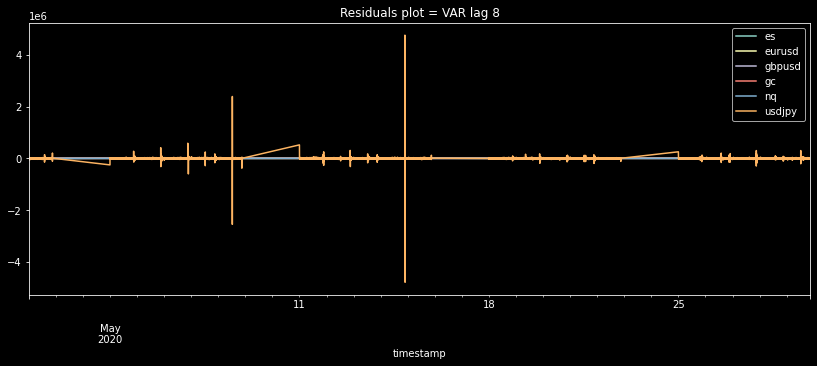

<IPython.core.display.Javascript object>

In [125]:
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# spliting train/test
nobs = 10 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
#print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
#print('Description of diff data:'); print(train_trans.describe());

import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_8 = VAR(endog = train_trans).fit(maxlags = 8)

from statsmodels.stats.stattools import durbin_watson
print('Durbin Watson statistic:')
out = durbin_watson(model_l_8.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))
print()

residuals = model_l_8.resid
residuals.plot(figsize=(14,5))
plt.title('Residuals plot = VAR lag 8')
plt.show()
print()

# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_8.k_ar
#print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

# Inversing difference
def inverse_diff(train, df_pred):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_pred.copy()
    columns = train_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_var[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
z = df_results.loc[:, ['es_fcast', 'eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]

In [126]:
print('Actual vs forecast:')
z.index = test_var.index
lag8 = pd.concat([test_var, z], axis=1)
lag8 = lag8[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'es','es_fcast','gc','gc_fcast','nq','nq_fcast']]
lag8 = lag8.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag8.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','es_fcast','gc_fcast']])



Actual vs forecast:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,es,es_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110720.673475,1237150.000000,1235472.134980,107835000.000000,107779474.610216,3027.250000,3027.219550,1731.350000,1731.809730,9591.125000,9587.682855
2020-05-29 20:59:00,1113400.000000,1110720.189034,1235450.000000,1235472.841678,107835000.000000,107779461.003842,3027.250000,3027.214354,1731.300000,1731.808504,9587.375000,9587.657311
2020-05-29 20:58:00,1111650.000000,1110719.440317,1235450.000000,1235473.743868,107830000.000000,107779446.790772,3027.250000,3027.209330,1731.450000,1731.807275,9588.625000,9587.632369
2020-05-29 20:57:00,1111750.000000,1110718.919549,1235450.000000,1235474.450519,107830000.000000,107779432.871366,3027.250000,3027.203692,1731.200000,1731.806015,9588.500000,9587.605301
2020-05-29 20:56:00,1111740.000000,1110719.134196,1235400.000000,1235474.667358,107675000.000000,107779421.346578,3027.250000,3027.198638,1731.500000,1731.804841,9588.625000,9587.580201
2020-05-29 20:55:00,1110660.000000,1110716.619451,1234990.000000,1235476.844851,107766500.000000,107779402.377704,3027.000000,3027.195158,1731.550000,1731.803617,9587.875000,9587.560653
2020-05-29 20:54:00,1110785.000000,1110716.796679,1235090.000000,1235477.137286,107788500.000000,107779388.780687,3026.625000,3027.185194,1731.750000,1731.802118,9586.375000,9587.518859
2020-05-29 20:53:00,1110845.000000,1110723.816640,1234890.000000,1235472.373105,107784500.000000,107779399.978182,3027.000000,3027.183327,1731.750000,1731.801320,9587.875000,9587.503955
2020-05-29 20:52:00,1110745.000000,1110702.119943,1235140.000000,1235486.357076,107779000.000000,107779373.988008,3027.000000,3027.195394,1731.500000,1731.799854,9586.875000,9587.535450


In [127]:
# EURUSD forcast validation
print('EURUSD forcast validation:')
m = lag8[['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])

EURUSD forcast validation:


/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110720.673000,99.76%
2020-05-29 20:59:00,1113400.000000,1110720.189000,99.76%
2020-05-29 20:58:00,1111650.000000,1110719.440000,99.92%
2020-05-29 20:57:00,1111750.000000,1110718.920000,99.91%
2020-05-29 20:56:00,1111740.000000,1110719.134000,99.91%
2020-05-29 20:55:00,1110660.000000,1110716.619000,100.01%
2020-05-29 20:54:00,1110785.000000,1110716.797000,99.99%
2020-05-29 20:53:00,1110845.000000,1110723.817000,99.99%
2020-05-29 20:52:00,1110745.000000,1110702.120000,100.00%


In [129]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag8.eurusd, lag8.eurusd_fcast)
mse = mean_squared_error(lag8.eurusd, lag8.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['eurusd'].values - lag8['eurusd_fcast'].values) / lag8['eurusd'].values)) * 100
msle = mean_squared_log_error(lag8.eurusd, lag8.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag8.gbpusd, lag8.gbpusd_fcast)
mse = mean_squared_error(lag8.gbpusd, lag8.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['gbpusd'].values - lag8['gbpusd_fcast'].values) / lag8['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag8.gbpusd, lag8.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag8.usdjpy, lag8.usdjpy_fcast)
mse = mean_squared_error(lag8.usdjpy, lag8.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['usdjpy'].values - lag8['usdjpy_fcast'].values) / lag8['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag8.usdjpy, lag8.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag8.nq, lag8.nq_fcast)
mse = mean_squared_error(lag8.nq, lag8.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['nq'].values - lag8['nq_fcast'].values) / lag8['nq'].values)) * 100
msle = mean_squared_log_error(lag8.nq, lag8.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score ES
mae = mean_absolute_error(lag8.es, lag8.es_fcast)
mse = mean_squared_error(lag8.es, lag8.es_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['es'].values - lag8['es_fcast'].values) / lag8['es'].values)) * 100
msle = mean_squared_log_error(lag8.es, lag8.es_fcast)
sum['ES'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag8.gc, lag8.gc_fcast)
mse = mean_squared_error(lag8.gc, lag8.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag8['gc'].values - lag8['gc_fcast'].values) /lag8['gc'].values)) * 100
msle = mean_squared_log_error(lag8.gc, lag8.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
print('Accuracy metrics:')
print(sum)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics:
                         Accuracy metrics :    EURUSD    GBPUSD        USDJPY   NQ   ES   GC
Mean Absolute Error                            868.56    386.78      34983.03 0.92 0.13 0.29
Mean squared error                         1735882.38 372681.25 2249267212.82 1.68 0.04 0.12
Root mean squared error                       1317.53    610.48      47426.44 1.30 0.21 0.35
Mean absolute % error                            0.08      0.03          0.03 0.01 0.00 0.02
Mean squared log Error                           0.00      0.00          0.00 0.00 0.00 0.00


# **4 VAR model fitting with lag 12:**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Durbin Watson statistic:
es : 2.0
eurusd : 2.0
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

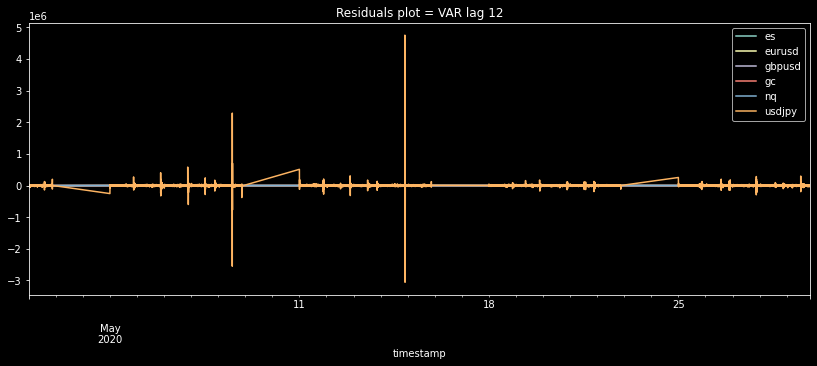

<IPython.core.display.Javascript object>

In [130]:
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# spliting train/test
nobs = 10 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
#print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
#print('Description of diff data:'); print(train_trans.describe());

import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_12 = VAR(endog = train_trans).fit(maxlags = 12)

from statsmodels.stats.stattools import durbin_watson
print('Durbin Watson statistic:')
out = durbin_watson(model_l_12.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))
print()

residuals = model_l_12.resid
residuals.plot(figsize=(14,5))
plt.title('Residuals plot = VAR lag 12')
plt.show()
print()

# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_12.k_ar
#print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

# Inversing difference
def inverse_diff(train, df_pred):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_pred.copy()
    columns = train_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_var[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
t = df_results.loc[:, ['es_fcast', 'eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]


In [131]:
print('Actual vs forecast:')
t.index = test_var.index
lag12 = pd.concat([test_var, t], axis=1)
lag12 = lag12[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'es','es_fcast','gc','gc_fcast','nq','nq_fcast']]
lag12 = lag12.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag12.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','es_fcast','gc_fcast']])

Actual vs forecast:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,es,es_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110720.673475,1237150.000000,1235472.134980,107835000.000000,107779474.610216,3027.250000,3027.219550,1731.350000,1731.809730,9591.125000,9587.682855
2020-05-29 20:59:00,1113400.000000,1110720.189034,1235450.000000,1235472.841678,107835000.000000,107779461.003842,3027.250000,3027.214354,1731.300000,1731.808504,9587.375000,9587.657311
2020-05-29 20:58:00,1111650.000000,1110719.440317,1235450.000000,1235473.743868,107830000.000000,107779446.790772,3027.250000,3027.209330,1731.450000,1731.807275,9588.625000,9587.632369
2020-05-29 20:57:00,1111750.000000,1110718.919549,1235450.000000,1235474.450519,107830000.000000,107779432.871366,3027.250000,3027.203692,1731.200000,1731.806015,9588.500000,9587.605301
2020-05-29 20:56:00,1111740.000000,1110719.134196,1235400.000000,1235474.667358,107675000.000000,107779421.346578,3027.250000,3027.198638,1731.500000,1731.804841,9588.625000,9587.580201
2020-05-29 20:55:00,1110660.000000,1110716.619451,1234990.000000,1235476.844851,107766500.000000,107779402.377704,3027.000000,3027.195158,1731.550000,1731.803617,9587.875000,9587.560653
2020-05-29 20:54:00,1110785.000000,1110716.796679,1235090.000000,1235477.137286,107788500.000000,107779388.780687,3026.625000,3027.185194,1731.750000,1731.802118,9586.375000,9587.518859
2020-05-29 20:53:00,1110845.000000,1110723.816640,1234890.000000,1235472.373105,107784500.000000,107779399.978182,3027.000000,3027.183327,1731.750000,1731.801320,9587.875000,9587.503955
2020-05-29 20:52:00,1110745.000000,1110702.119943,1235140.000000,1235486.357076,107779000.000000,107779373.988008,3027.000000,3027.195394,1731.500000,1731.799854,9586.875000,9587.535450


In [132]:
# EURUSD forcast validation
print('EURUSD forcast validation:')
m = lag12[['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


EURUSD forcast validation:


/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110720.673000,99.76%
2020-05-29 20:59:00,1113400.000000,1110720.189000,99.76%
2020-05-29 20:58:00,1111650.000000,1110719.440000,99.92%
2020-05-29 20:57:00,1111750.000000,1110718.920000,99.91%
2020-05-29 20:56:00,1111740.000000,1110719.134000,99.91%
2020-05-29 20:55:00,1110660.000000,1110716.619000,100.01%
2020-05-29 20:54:00,1110785.000000,1110716.797000,99.99%
2020-05-29 20:53:00,1110845.000000,1110723.817000,99.99%
2020-05-29 20:52:00,1110745.000000,1110702.120000,100.00%


In [133]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag12.eurusd, lag12.eurusd_fcast)
mse = mean_squared_error(lag12.eurusd, lag12.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['eurusd'].values - lag12['eurusd_fcast'].values) / lag12['eurusd'].values)) * 100
msle = mean_squared_log_error(lag12.eurusd, lag12.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag12.gbpusd, lag12.gbpusd_fcast)
mse = mean_squared_error(lag12.gbpusd, lag12.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['gbpusd'].values - lag12['gbpusd_fcast'].values) / lag12['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag12.gbpusd, lag12.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag12.usdjpy, lag12.usdjpy_fcast)
mse = mean_squared_error(lag12.usdjpy, lag12.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['usdjpy'].values - lag12['usdjpy_fcast'].values) / lag12['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag12.usdjpy, lag12.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag12.nq, lag12.nq_fcast)
mse = mean_squared_error(lag12.nq, lag12.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['nq'].values - lag12['nq_fcast'].values) / lag12['nq'].values)) * 100
msle = mean_squared_log_error(lag12.nq, lag12.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score ES
mae = mean_absolute_error(lag12.es, lag12.es_fcast)
mse = mean_squared_error(lag12.es, lag12.es_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['es'].values - lag12['es_fcast'].values) / lag12['es'].values)) * 100
msle = mean_squared_log_error(lag12.es, lag12.es_fcast)
sum['ES'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag12.gc, lag12.gc_fcast)
mse = mean_squared_error(lag12.gc, lag12.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag12['gc'].values - lag12['gc_fcast'].values) / lag12['gc'].values)) * 100
msle = mean_squared_log_error(lag12.gc, lag12.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
print('Accuracy metrics:')
print(sum)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics:
                         Accuracy metrics :    EURUSD    GBPUSD        USDJPY   NQ   ES   GC
Mean Absolute Error                            868.56    386.78      34983.03 0.92 0.13 0.29
Mean squared error                         1735882.38 372681.25 2249267212.82 1.68 0.04 0.12
Root mean squared error                       1317.53    610.48      47426.44 1.30 0.21 0.35
Mean absolute % error                            0.08      0.03          0.03 0.01 0.00 0.02
Mean squared log Error                           0.00      0.00          0.00 0.00 0.00 0.00


# **5 VAR model fitting with lag 31:**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Durbin Watson statistic:
es : 2.0
eurusd : 2.0
gbpusd : 2.0
gc : 2.0
nq : 2.0
usdjpy : 2.0



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

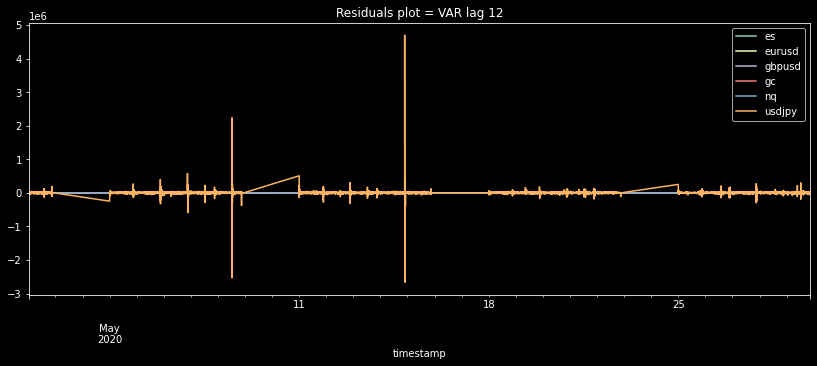

<IPython.core.display.Javascript object>

In [134]:
df = pd.read_csv("AL_final_data.csv")
df.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
df = df.set_index('timestamp')
df.index = pd.to_datetime(df.index)

# spliting train/test
nobs = 10 # keeping 10 mins observations aside for validation
train_var, test_var = df[0:- nobs], df[- nobs:]

# Check size
#print(train_var.shape); print(test_var.shape);

# transfoming training data set
train_trans = train_var.diff().dropna() # differencing
#print('Description of diff data:'); print(train_trans.describe());

import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR

# pass "1min" frequency
train_trans.index = pd.DatetimeIndex(train_trans.index).to_period('1min')

# fitting VAR model with associated freq & lags
model_l_31 = VAR(endog = train_trans).fit(maxlags = 31)

from statsmodels.stats.stattools import durbin_watson
print('Durbin Watson statistic:')
out = durbin_watson(model_l_12.resid)

for col, val in zip(train_var.columns, out):
    print((col), ':', round(val, 2))
print()

residuals = model_l_31.resid
residuals.plot(figsize=(14,5))
plt.title('Residuals plot = VAR lag 12')
plt.show()
print()

# Forecasting
pd.options.display.float_format = "{:.2f}".format
# Get the lag order
lag_order = model_l_31.k_ar
#print(lag_order) 

# Input data for forecasting
input_data = train_trans.values[-lag_order:]
#print(input_data)

# Inversing difference
def inverse_diff(train, df_pred):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_pred.copy()
    columns = train_var.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_fcast'] = train_var[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = inverse_diff(train_var, df_pred)        
t = df_results.loc[:, ['es_fcast', 'eurusd_fcast', 'gbpusd_fcast', 
                       'gc_fcast','nq_fcast', 'usdjpy_fcast']]


In [135]:
print('Actual vs forecast:')
t.index = test_var.index
lag31 = pd.concat([test_var, t], axis=1)
lag31 = lag31[['eurusd','eurusd_fcast','gbpusd','gbpusd_fcast','usdjpy','usdjpy_fcast',
                 'es','es_fcast','gc','gc_fcast','nq','nq_fcast']]
lag31 = lag31.sort_values(by='timestamp', ascending=False)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
lag31.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast','gbpusd_fcast','usdjpy_fcast',
                                                               'nq_fcast','es_fcast','gc_fcast']])

Actual vs forecast:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,gbpusd,gbpusd_fcast,usdjpy,usdjpy_fcast,es,es_fcast,gc,gc_fcast,nq,nq_fcast
timestamp,,,,,,,,,,,,
2020-05-29 21:00:00,1113400.000000,1110720.673475,1237150.000000,1235472.134980,107835000.000000,107779474.610216,3027.250000,3027.219550,1731.350000,1731.809730,9591.125000,9587.682855
2020-05-29 20:59:00,1113400.000000,1110720.189034,1235450.000000,1235472.841678,107835000.000000,107779461.003842,3027.250000,3027.214354,1731.300000,1731.808504,9587.375000,9587.657311
2020-05-29 20:58:00,1111650.000000,1110719.440317,1235450.000000,1235473.743868,107830000.000000,107779446.790772,3027.250000,3027.209330,1731.450000,1731.807275,9588.625000,9587.632369
2020-05-29 20:57:00,1111750.000000,1110718.919549,1235450.000000,1235474.450519,107830000.000000,107779432.871366,3027.250000,3027.203692,1731.200000,1731.806015,9588.500000,9587.605301
2020-05-29 20:56:00,1111740.000000,1110719.134196,1235400.000000,1235474.667358,107675000.000000,107779421.346578,3027.250000,3027.198638,1731.500000,1731.804841,9588.625000,9587.580201
2020-05-29 20:55:00,1110660.000000,1110716.619451,1234990.000000,1235476.844851,107766500.000000,107779402.377704,3027.000000,3027.195158,1731.550000,1731.803617,9587.875000,9587.560653
2020-05-29 20:54:00,1110785.000000,1110716.796679,1235090.000000,1235477.137286,107788500.000000,107779388.780687,3026.625000,3027.185194,1731.750000,1731.802118,9586.375000,9587.518859
2020-05-29 20:53:00,1110845.000000,1110723.816640,1234890.000000,1235472.373105,107784500.000000,107779399.978182,3027.000000,3027.183327,1731.750000,1731.801320,9587.875000,9587.503955
2020-05-29 20:52:00,1110745.000000,1110702.119943,1235140.000000,1235486.357076,107779000.000000,107779373.988008,3027.000000,3027.195394,1731.500000,1731.799854,9586.875000,9587.535450


In [136]:
# EURUSD forcast validation
print('EURUSD forcast validation:')
m = lag31[['eurusd', 'eurusd_fcast']]
m['accuracy'] = round(m.apply(lambda row: row.eurusd_fcast / 
                                            row.eurusd *100, axis = 1),2)
m['accuracy'] = pd.Series(["{0:.2f}%".format(val) for val in m['accuracy']], 
                                     index = m.index)
m = m.round(decimals=3)
m = m.head(10)
def highlight_cols(s):
    color = 'yellow'
    return 'background-color: %s' % color
m.style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['eurusd_fcast']])


EURUSD forcast validation:


/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/pyforest/__init__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

,eurusd,eurusd_fcast,accuracy
timestamp,,,
2020-05-29 21:00:00,1113400.000000,1110720.673000,99.76%
2020-05-29 20:59:00,1113400.000000,1110720.189000,99.76%
2020-05-29 20:58:00,1111650.000000,1110719.440000,99.92%
2020-05-29 20:57:00,1111750.000000,1110718.920000,99.91%
2020-05-29 20:56:00,1111740.000000,1110719.134000,99.91%
2020-05-29 20:55:00,1110660.000000,1110716.619000,100.01%
2020-05-29 20:54:00,1110785.000000,1110716.797000,99.99%
2020-05-29 20:53:00,1110845.000000,1110723.817000,99.99%
2020-05-29 20:52:00,1110745.000000,1110702.120000,100.00%


In [137]:
# Accuracy metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_error, mean_squared_log_error

# score EURUSD
mae = mean_absolute_error(lag31.eurusd, lag31.eurusd_fcast)
mse = mean_squared_error(lag31.eurusd, lag31.eurusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['eurusd'].values - lag31['eurusd_fcast'].values) / lag31['eurusd'].values)) * 100
msle = mean_squared_log_error(lag31.eurusd, lag31.eurusd_fcast)
sum = DataFrame(index = ['Mean Absolute Error', 'Mean squared error', 'Root mean squared error',
                            'Mean absolute % error','Mean squared log Error'])
sum['Accuracy metrics :    EURUSD'] = [mae, mse, rmse, mape, msle]

# score GBPUSD
mae = mean_absolute_error(lag31.gbpusd, lag31.gbpusd_fcast)
mse = mean_squared_error(lag31.gbpusd, lag31.gbpusd_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['gbpusd'].values - lag31['gbpusd_fcast'].values) / lag31['gbpusd'].values)) * 100
msle = mean_squared_log_error(lag31.gbpusd, lag31.gbpusd_fcast)
sum['GBPUSD'] = [mae, mse, rmse, mape, msle]

# score USDJPY
mae = mean_absolute_error(lag31.usdjpy, lag31.usdjpy_fcast)
mse = mean_squared_error(lag31.usdjpy, lag31.usdjpy_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['usdjpy'].values - lag31['usdjpy_fcast'].values) / lag31['usdjpy'].values)) * 100
msle = mean_squared_log_error(lag31.usdjpy, lag31.usdjpy_fcast)
sum['USDJPY'] = [mae, mse, rmse, mape, msle]

# score NQ
mae = mean_absolute_error(lag31.nq, lag31.nq_fcast)
mse = mean_squared_error(lag31.nq, lag31.nq_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['nq'].values - lag31['nq_fcast'].values) / lag31['nq'].values)) * 100
msle = mean_squared_log_error(lag31.nq, lag31.nq_fcast)
sum['NQ'] = [mae, mse, rmse, mape, msle]

# score ES
mae = mean_absolute_error(lag31.es, lag31.es_fcast)
mse = mean_squared_error(lag31.es, lag31.es_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['es'].values - lag31['es_fcast'].values) / lag31['es'].values)) * 100
msle = mean_squared_log_error(lag31.es, lag31.es_fcast)
sum['ES'] = [mae, mse, rmse, mape, msle]

# score GC
mae = mean_absolute_error(lag31.gc, lag31.gc_fcast)
mse = mean_squared_error(lag31.gc, lag31.gc_fcast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((lag31['gc'].values - lag31['gc_fcast'].values) / lag31['gc'].values)) * 100
msle = mean_squared_log_error(lag31.gc, lag31.gc_fcast)
sum['GC'] = [mae, mse, rmse, mape, msle]
print('Accuracy metrics:')
print(sum)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy metrics:
                         Accuracy metrics :    EURUSD    GBPUSD        USDJPY   NQ   ES   GC
Mean Absolute Error                            868.56    386.78      34983.03 0.92 0.13 0.29
Mean squared error                         1735882.38 372681.25 2249267212.82 1.68 0.04 0.12
Root mean squared error                       1317.53    610.48      47426.44 1.30 0.21 0.35
Mean absolute % error                            0.08      0.03          0.03 0.01 0.00 0.02
Mean squared log Error                           0.00      0.00          0.00 0.00 0.00 0.00
